In [1]:
%matplotlib notebook

import os
import time
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td 
import torchvision as tv
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt 
from itertools import chain

from cGAN_model.DnCNN import DnCNN
import cGAN_model.nntools as nt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


## Class used for loading content for training or testing

| Artist Num |      Artist      | Artist Num |        Artist       | Artist Num |         Artist        | Artist Num |       Artist       |
|:----------:|:----------------:|:----------:|:-------------------:|:----------:|:---------------------:|:----------:|:------------------:|
|      0     |  Albrecht_Durer  |      6     |    Eugene_Boudin    |     12     |      Marc_Chagall     |     18     | Pyotr_Konchalovsky |
|      1     |  Boris_Kustodiev |      7     |     Gustave_Dore    |     13     |    Martiros_Saryan    |     19     |  Raphael_Kirchner  |
|      2     | Camille_Pissarro |      8     |      Ilya_Repin     |     14     |    Nicholas_Roerich   |     20     |      Rembrandt     |
|      3     |   Childe_Hassam  |      9     |   Ivan_Aivazovsky   |     15     |     Pablo_Picasso     |     21     |    Salvador_Dali   |
|      4     |   Claude_Monet   |     10     |    Ivan_Shishkin    |     16     |      Paul_Cezanne     |     22     |  Vincent_van_Gogh  |
|      5     |    Edgar_Degas   |     11     | John_Singer_Sargent |     17     | Pierre_Auguste_Renoir |            |                    |

In [3]:
class StyleGroupDataset(td.Dataset):
    def __init__(self, content_root_dir, style_root_dir,
                 content_categories, artist = 22, mode="train", trainCat = "Artist", 
                 image_size=(150, 150), sigma=30):
        assert type(content_categories) == list, "input content_categories must be a list"
        assert 0 <= artist <= 22, "invalid artist"
        
        super(StyleGroupDataset, self).__init__()
        
        self.image_size = image_size
        self.sigma = sigma
        self.mode = mode
        self.content_cat = content_categories
        self.content_files = []
        
        for content_category in content_categories:
            content_dir = os.path.join(content_root_dir, content_category) 
            self.content_files += [os.path.join(content_dir, f) for f in os.listdir(content_dir)]
        
        self.artist = artist
        self.style_files = pd.read_csv(os.path.join(style_root_dir, f"{trainCat}/{trainCat.lower()}_{mode}" ))
        self.style_files = self.style_files.loc[self.style_files.iloc[:,2] == self.artist]   # vincent-van-gogh
        self.images_dir = os.path.join(style_root_dir,'wikiart')
        
        self.transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ])

    def __len__(self):
        return len(self.style_files)
    
    def content_num(self):
        return len(self.content_files)
    
    def style_num(self):
        return len(self.style_files)

    def __repr__(self):
        return f"Dataset(mode={self.mode}, image_size={self.image_size}, artist={self.artist}, content={self.content_cat})"
    
    def __getitem__(self, idx):
        content_idx = idx % self.content_num()
        style_idx = idx % self.style_num()
        
        content = Image.open(self.content_files[idx]).convert('RGB')
        
        style_path = os.path.join(self.images_dir, self.style_files.iloc[style_idx][0])
        style = Image.open(style_path).convert('RGB')

        content = self.transform(content)
        style = self.transform(style)
        return content, style

In [4]:
class ContentTestDataset(td.Dataset):

    def __init__(self, content_root_dir, content_category, 
                 image_size=(150, 150), sigma=30): 
        super(ContentTestDataset, self).__init__()
        self.content_cat = content_category
        self.image_size = image_size
        self.sigma = sigma
        
        self.content_dir = os.path.join(content_root_dir, content_category) 
        self.content_files = os.listdir(self.content_dir)
        
        self.transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ])
        
    def __len__(self):
        return len(self.content_files) 
    
    def content_num(self):
        return len(self.content_files)
    
    def __repr__(self):
        return (f"StyleTransDataset(category: {self.content_cat}"
                f", image_size={self.image_size}, sigma={self.sigma})")

    def __getitem__(self, idx):
        content_path = os.path.join(self.content_dir, self.content_files[idx]) 
        content = Image.open(content_path).convert('RGB')
          
        return self.transform(content)

| content |        |          |       |
|---------|--------|----------|-------|
|   city  | forest | licenses | ocean |
|  field  |  lake  | mountain |  road |

In [5]:
content_root_dir = "/datasets/ee285f-public/flickr_landscape/"
style_root_dir = "/datasets/ee285f-public/wikiart/"

train_set = StyleGroupDataset(content_root_dir, style_root_dir,
                              content_categories=["city"])

long_train_set = StyleGroupDataset(content_root_dir, style_root_dir,
                                  content_categories=["forest", "lake", "city"])


test_set = ContentTestDataset(content_root_dir, "road")

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

## Generator and Discriminator for GAN

### Generator use DnCNN from HW4, with MSE loss

### Discriminator use 4 layers of CNN (3 -> 16, 64, 256, 256) along with instNorm and RELU for transforming the image. Then, it use CNN(256 -> 1) for discriminating decision making

In [7]:
class Generator(DnCNN):
    def __init__(self, D, C=64):
        super(Generator, self).__init__(D)
        
class Discriminator(nt.NeuralNetwork):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.cnn = nn.Sequential()
        dims = [3, 16, 64, 256, 256]
        for i in range(len(dims) - 1):
            self.cnn.add_module(f"conv2d{i}", nn.Conv2d(dims[i], dims[i + 1], 3, padding = 1))
            self.cnn.add_module(f"instNorm{i}", nn.InstanceNorm2d(dims[i + 1]))
            self.cnn.add_module(f"relu{i}", nn.LeakyReLU(0.2, True))
        
        self.cnn.add_module("cov2dFL", nn.Conv2d(256, 1, 3, padding=1, bias=False))
        
    def forward(self, x):
        h = self.cnn(x)
        h = h.view(h.size(0), -1) # reshape to 2D (batch_size * (img_w * img*h))
        return h
    
    def criterion(self, y, d):
        return nn.L1Loss()(y, d)

### Trainer class used to train cycle GAN, geting loss/gradient for generator and discriminator and do optimization with Adam. 

In [8]:
class CGANTrainer():

    def __init__(self, device, D=6):
        self.device = device
        
        self.gen2s = Generator(D).to(device)
        self.gen2c = Generator(D).to(device)
        self.dis_c = Discriminator().to(device)
        self.dis_s = Discriminator().to(device)
        
        self.lr = 2e-3
        self.adam_gen = torch.optim.Adam(chain(self.gen2s.parameters(), self.gen2c.parameters()), 
                                         lr=self.lr, betas=(0.5,0.999))
        self.adam_dis_c = torch.optim.Adam(self.dis_c.parameters(), lr=self.lr, betas=(0.5,0.999))
        self.adam_dis_s = torch.optim.Adam(self.dis_s.parameters(), lr=self.lr, betas=(0.5,0.999))
        
        self.scheduler_gen = torch.optim.lr_scheduler.StepLR(self.adam_gen, step_size=2, gamma=0.99)
        self.scheduler_dis_c = torch.optim.lr_scheduler.StepLR(self.adam_dis_c, step_size=2, gamma=0.99)
        self.scheduler_dis_s = torch.optim.lr_scheduler.StepLR(self.adam_dis_s, step_size=2, gamma=0.99)
        
        self.l1Loss = nn.L1Loss().to(self.device)
        self.l2Loss = nn.MSELoss().to(self.device)
        
    def forward(self, content, style):
        """
        Prepare generated tensors for training.
        Must be called before calling train_generator/train_discriminator
        """
        self.content = content
        self.style = style
        self.S_c = self.gen2s(content)
        self.C_S_c = self.gen2c(self.S_c)
        self.C_s = self.gen2c(style)
        self.S_C_s = self.gen2s(self.C_s)
        
    def train_generator(self):  
        self.adam_gen.zero_grad()

        totalLoss = 0

        # get Discriminator Loss
        disS= self.dis_s(self.S_c)
        real_var = Variable(torch.cuda.FloatTensor(disS.shape).fill_(1.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(disS, real_var)
        
        disC = self.dis_c(self.C_s)
        real_var = Variable(torch.cuda.FloatTensor(disC.shape).fill_(1.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(disC, real_var)

        # get Cycle GAN Loss
        totalLoss += self.l1Loss(self.C_S_c, self.content)
        totalLoss += self.l1Loss(self.S_C_s, self.style)

        # update generator
        totalLoss.backward()
        self.adam_gen.step()
        return totalLoss
    
    def train_discriminator(self, mode):
        """
        Train the discriminator. 
        mode == 0: train the discriminator for style 
        mode == 1: train the discriminator for content
        """

        assert (mode == 0 or mode == 1), "input must be 0(train dis_s) or 1(train dis_c)" 

        if mode == 0:
            # Train the style discriminator           
            adam_dis = self.adam_dis_s
            dis, gen, ori = self.dis_s, self.S_c, self.style
        else:
            # Train the content discriminator
            adam_dis = self.adam_dis_c
            dis, gen, ori = self.dis_c, self.C_s, self.content
        
            
        adam_dis.zero_grad()   
        totalLoss = 0
        
        disReal = dis(ori)
        real_var = Variable(torch.cuda.FloatTensor(disReal.shape).fill_(1.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(disReal, real_var)
        
        # get Discriminator Loss
        dis_fake = dis(gen.detach())
        fake_var = Variable(torch.cuda.FloatTensor(dis_fake.shape).fill_(0.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(dis_fake, fake_var)
        
        # update discriminator
        totalLoss.backward()
        adam_dis.step()
        return totalLoss
    
    def train(self, content, style):
        dis_loss, gen_loss = 0, 0 
        
        self.forward(content, style)
        # train discrimiator
        dis_loss += self.train_discriminator(0).item()
        dis_loss += self.train_discriminator(1).item()
            
        # train generator
        gen_loss = self.train_generator().item()
        
        return gen_loss, dis_loss, dis_loss + gen_loss
    
    def update_lr(self):
        self.scheduler_gen.step()
        self.scheduler_dis_c.step()
        self.scheduler_dis_s.step()

### Experiment inherited from nt.Experiment. Being able to run experiment, save/load check points.

In [9]:
class CGANexp(nt.Experiment):
    def __init__(self, cGANTrainer, train_set, output_dir, style_ref,
                 picNum = 100, batch_size=16, device = device,
                 perform_validation_during_training=False):  
        # Initialize
        self.history = []
        self.trainer = cGANTrainer
        self.device = device
        self.train_set = train_set
        self.style_ref = style_ref
        
        self.picNum = picNum
        self.net = self.trainer.gen2c

        self.train_loader = td.DataLoader(train_set,
                  batch_size=4, shuffle=True, 
                  drop_last=True, pin_memory=True)
                
        # Key:Value pair
        self.toRecover = {
            'contentGenNet': self.trainer.gen2c,
            'styleGenNet': self.trainer.gen2s,
            'contentDisNet': self.trainer.dis_c,
            'styleDisNet': self.trainer.dis_s,
            'genAdam': self.trainer.adam_gen,
            'contentDisAdam': self.trainer.adam_dis_c,
            'styleDisAdam': self.trainer.adam_dis_s,
            'history': self.history
           }
        
        # Define checkpoint paths
        if output_dir is None:
            output_dir = 'experiment_{}'.format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        self.checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        self.config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(self.config_path):
            with open(self.config_path, 'r') as f:
                config = f.read()[:-1]
                for key in self.toRecover:
                    if key not in config and key != "history":
                        raise ValueError(
                        "Cannot create this experiment: "
                        "I found a checkpoint conflicting with the current setting.\n"
                        f"{key} doesn't exsit in config")
            self.load()
            print("Done Load from Checkpoint!")
        else:
            self.save()
        
    def setting(self):
        """Returns the setting of the experiment."""
        return {'contentGenNet': self.trainer.gen2c,
                'styleGenNet': self.trainer.gen2s,
                'contentDisNet': self.trainer.dis_c,
                'styleDisNet': self.trainer.dis_s,
                'genAdam': self.trainer.adam_gen,
                'contentDisAdam': self.trainer.adam_dis_c,
                'styleDisAdam': self.trainer.adam_dis_s,
                'BatchSize': self.batch_size,
                'PerformValidationDuringTraining': self.perform_validation_during_training}

    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string
    
    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'contentGenNet': self.trainer.gen2c.state_dict(),
                'styleGenNet': self.trainer.gen2s.state_dict(),
                'contentDisNet': self.trainer.dis_c.state_dict(),
                'styleDisNet': self.trainer.dis_s.state_dict(),
                'genAdam': self.trainer.adam_gen.state_dict(),
                'contentDisAdam': self.trainer.adam_dis_c.state_dict(),
                'styleDisAdam': self.trainer.adam_dis_s.state_dict(),
                'history': self.history
               }
    
    
    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        for key, val in checkpoint.items():
            if key not in self.toRecover:
                raise AttributeError(f"Loading is Wrong! Key is {key}")
            if key == 'history':
                self.history = val
            else:
                self.toRecover[key].load_state_dict(val)
               
        nets = [self.trainer.gen2c, self.trainer.gen2s, 
                self.trainer.dis_c, self.trainer.dis_s]
        adams = [self.trainer.adam_gen, self.trainer.adam_gen,
                 self.trainer.adam_dis_c, self.trainer.adam_dis_s]
        
        for net, optimizer in zip(nets, adams):
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(self.device)
                        
    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.device)
        self.load_state_dict(checkpoint)
        del checkpoint
        
    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
        
    def run(self, num_epochs, plot=None, save_path=None):
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        
        if plot is not None:
            fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6)) 
            plot(self, fig, axes)
                
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            i = 0
            gen_loss, dis_loss, total_loss = [], [], []
            
            for content, style in self.train_loader:
                if i > self.picNum:
                    break
                content = content.to(self.device)
                style = style.to(self.device)
                
                lg, ld, lt = self.trainer.train(content, style)
                dis_loss.append(ld)
                gen_loss.append(lg)
                total_loss.append(lt)
                
                i += 1
            
            self.trainer.update_lr()
                
            self.history.append((np.mean(total_loss), 
                                 np.mean(gen_loss), 
                                 np.mean(dis_loss)))
            
            print("Epoch {} (Time: {:.2f}s)".format(
                self.epoch, time.time() - s))
            self.save()
            if plot is not None:
                plot(self, fig, axes)
                
        if plot is not None and save_path is not None:
            plot(self, fig=fig, axes=axes, save_path=save_path)

### Helper functions for plotting and visualizing

In [10]:
def plot_basic(exp, fig, axes, content, style, visu_rate=2, save_path=None): 
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        transfered = exp.trainer.gen2s(content[np.newaxis].to(exp.trainer.gen2s.device))[0] 
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(content, ax=axes[0][0]) 
    axes[0][0].set_title('Content image') 
    
    myimshow(style, ax=axes[0][1]) 
    axes[0][1].set_title('Style image')

    myimshow(transfered, ax=axes[1][0]) 
    axes[1][0].set_title('Transfered image')
    
    axes[1][1].plot([exp.history[k][0].item() 
                     for k in range(exp.epoch)],label="Total Loss")
    axes[1][1].plot([exp.history[k][1].item() 
                     for k in range(exp.epoch)],label="Gen Loss")
    axes[1][1].plot([exp.history[k][2].item()
                     for k in range(exp.epoch)],label="Dis Loss")
    
    axes[1][1].legend(loc='best')
    
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("Loss")
    
    plt.tight_layout() 
    fig.canvas.draw()
    
    if save_path is not None:
        fig.savefig(save_path)

def plot_exp(exp, fig, axes, ind=0, save_path=None):
    if save_path is not None:
        save_path = "./proj_report_img/" + save_path
    
    plot_basic(exp, fig = fig,
               axes = axes,content = train_set[ind][0],
               style = train_set[ind][1],
               save_path = save_path)
    
def multi_final_result(save_path, use_train, exp, *test_ids):
    assert (save_path==None or type(save_path)==str), "first input must be string for save path" 
    assert (type(use_train)==bool), "second input must be True or False" 
    
    img_num = len(test_ids)
    fig, axes = plt.subplots(ncols=img_num, nrows=2) 
    
    for i in range(img_num):
        if use_train:
            to_test = long_train_set[test_ids[i]][0][np.newaxis].to(device)
        else:
            to_test = test_set[test_ids[i]][np.newaxis].to(device)
            
        myimshow(to_test[0], axes[0][i])
        
        with torch.no_grad():
            myimshow(exp.trainer.gen2s(to_test)[0] , ax=axes[1][i])
            
        axes[0][i].set_title("Original")
        axes[1][i].set_title("Transferred")
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig("./proj_report_img/" + save_path)

### Init networks & experiment for demo

In [11]:
cycleGan_trainer_short = CGANTrainer(device)
domain_exp_short = CGANexp(cycleGan_trainer_short, train_set, 
                           output_dir="./cGAN_ckpts/cycleGAN_group_ckpt", 
                           style_ref = None, batch_size = 4, picNum = 20, 
                           perform_validation_during_training=True)

cycleGan_trainer_long = CGANTrainer(device)
domain_exp_long = CGANexp(cycleGan_trainer_long, long_train_set, 
                          output_dir="./cGAN_ckpts/cycleGAN_group_ckpt_long", 
                          style_ref = None, batch_size = 2, picNum = 1000, 
                          perform_validation_during_training=True)

cycleGan_trainer_largeBS = CGANTrainer(device)
domain_exp_largeBS = CGANexp(cycleGan_trainer_largeBS, train_set, 
                           output_dir="./cGAN_ckpts/large_bs", 
                           style_ref = None, picNum = 1000, 
                           perform_validation_during_training=True)

cycleGan_trainer_largeBS_decay = CGANTrainer(device)
domain_exp_largeBS_decay = CGANexp(cycleGan_trainer_largeBS, long_train_set, 
                           output_dir="./cGAN_ckpts/large_bs_decay", 
                           style_ref = None, picNum = 1000, 
                           perform_validation_during_training=True)

Done Load from Checkpoint!
Done Load from Checkpoint!
Done Load from Checkpoint!
Done Load from Checkpoint!


### Train for all successful models

Start/Continue training from epoch 200


<IPython.core.display.Javascript object>


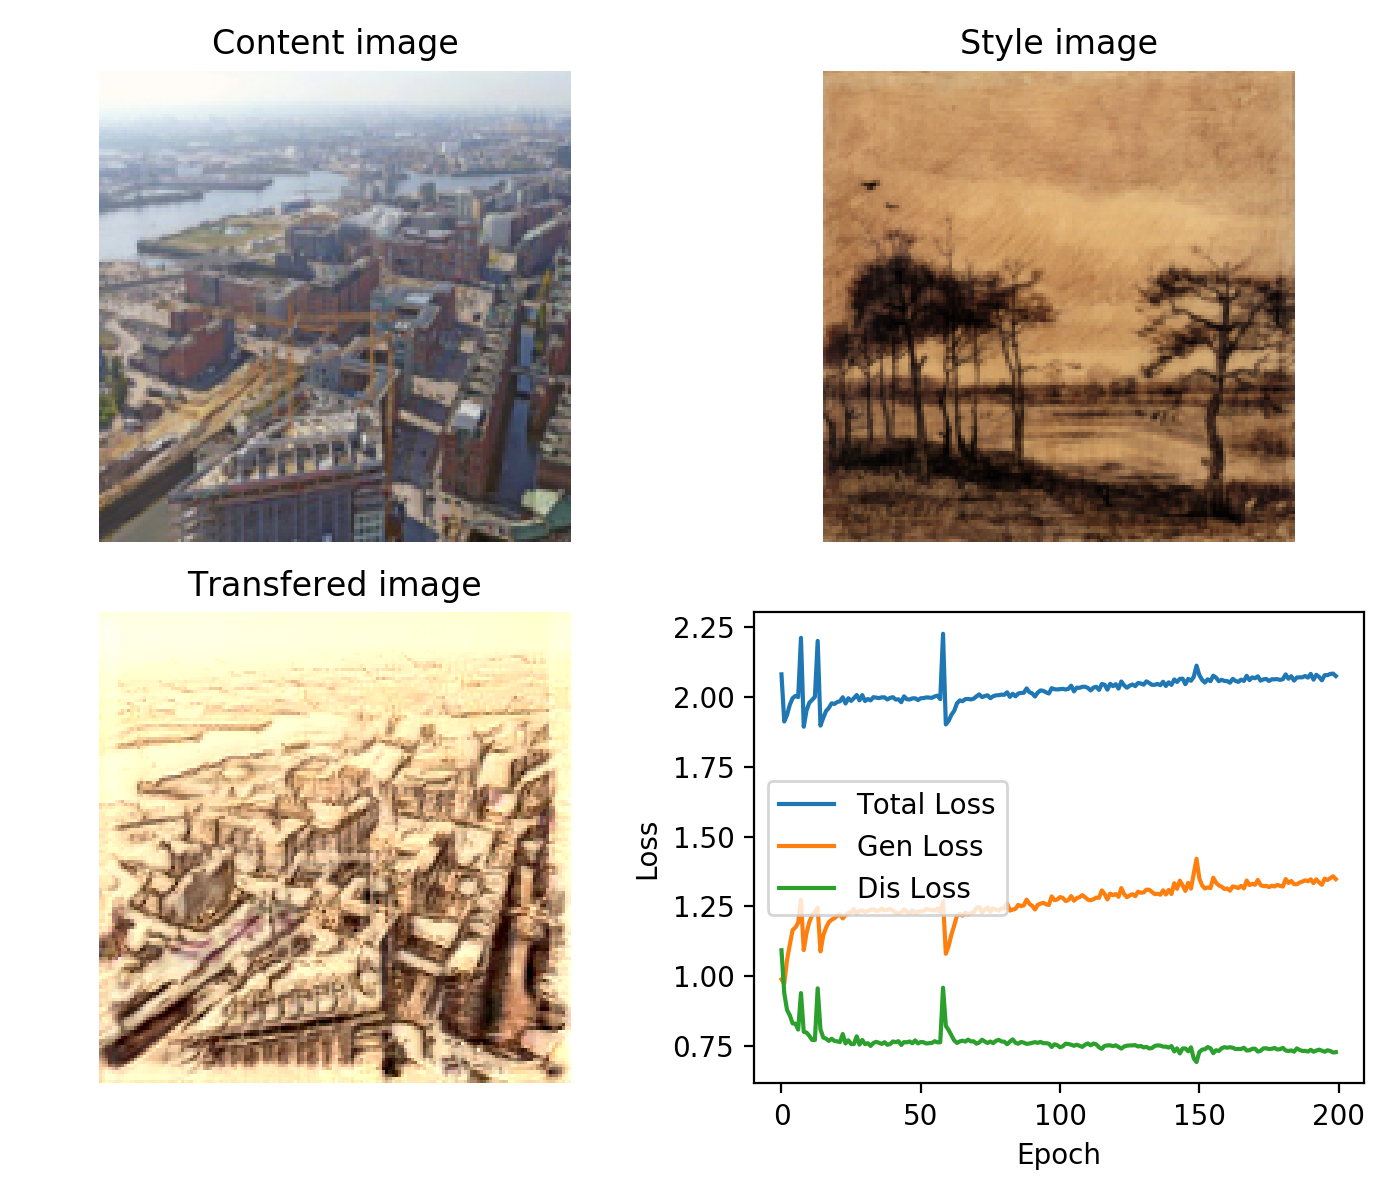

In [12]:
domain_exp_largeBS.run(num_epochs=200, plot=plot_exp)

Start/Continue training from epoch 200


<IPython.core.display.Javascript object>


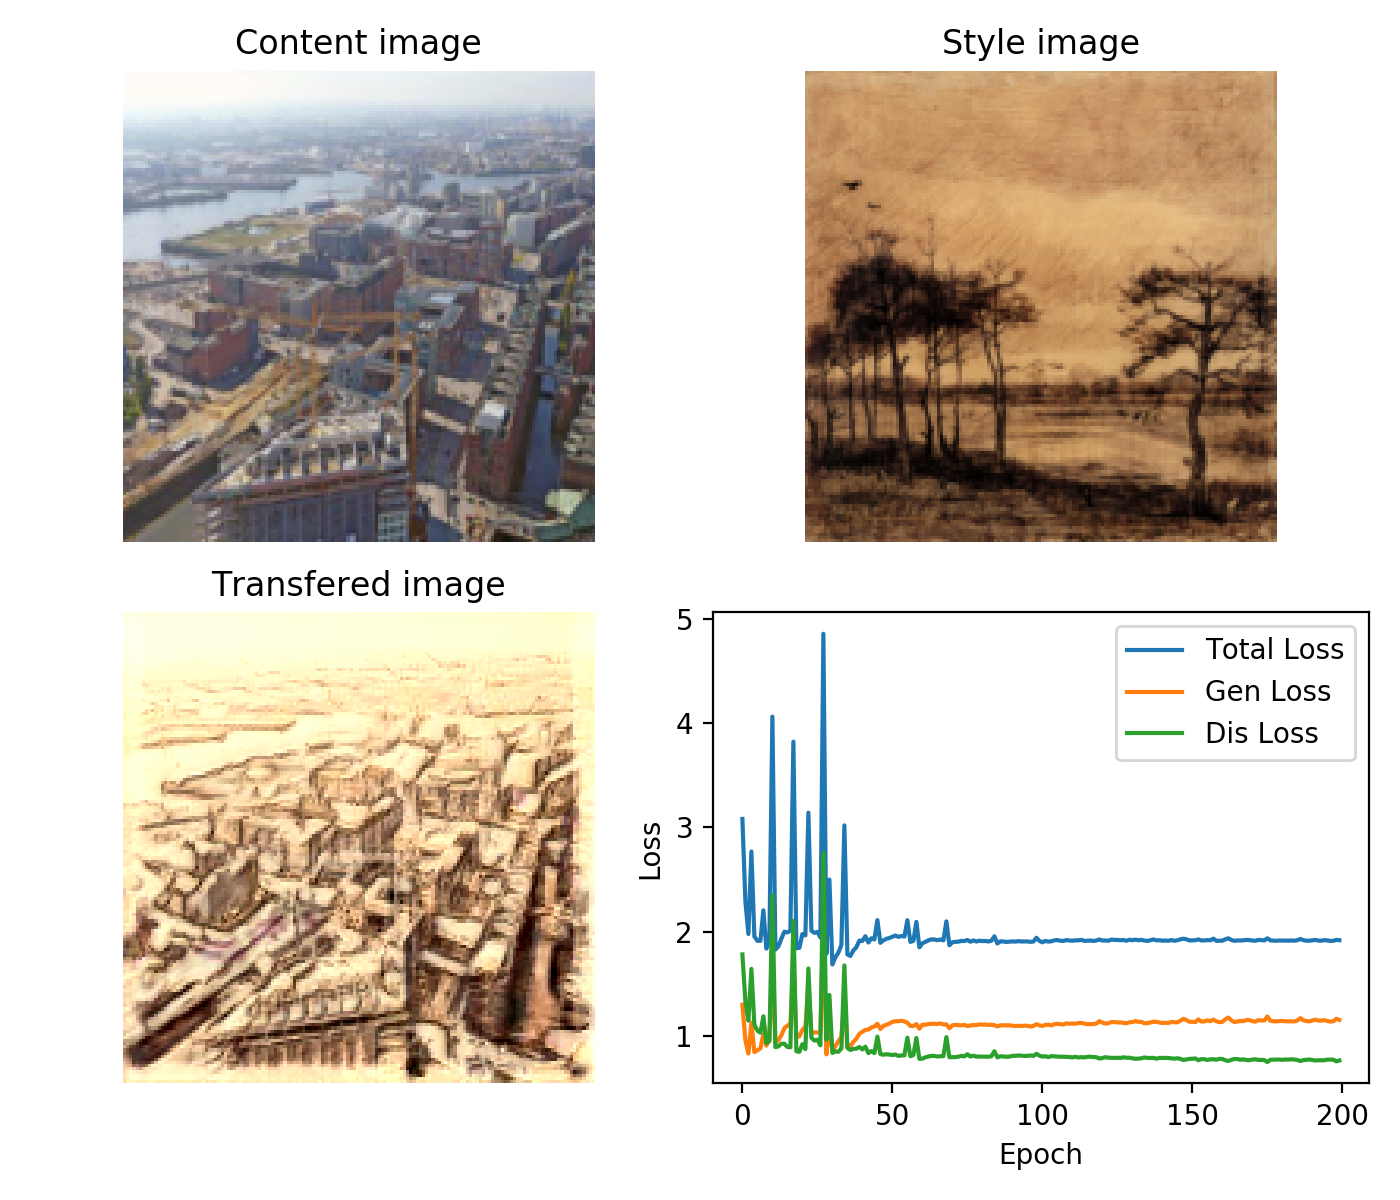

In [13]:
domain_exp_largeBS_decay.run(num_epochs=200, plot=plot_exp, save_path="domain_exp_largeBS_decay_train.png")

### Test for domain_large_bs

<IPython.core.display.Javascript object>


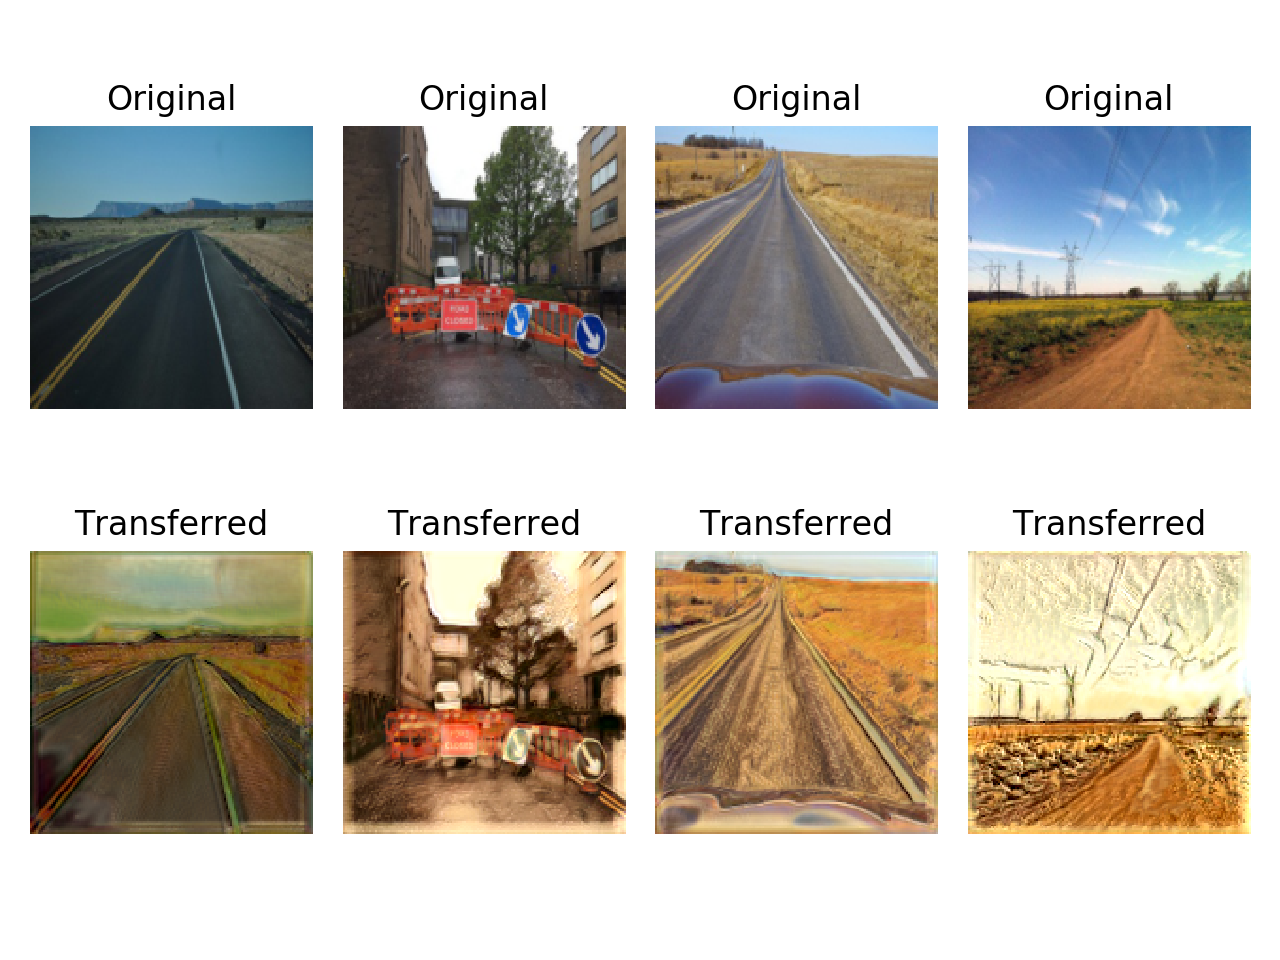

In [14]:
multi_final_result(None, False, domain_exp_largeBS, 230, 231, 300, 330)

### Test for domain_large_bs_decay

<IPython.core.display.Javascript object>


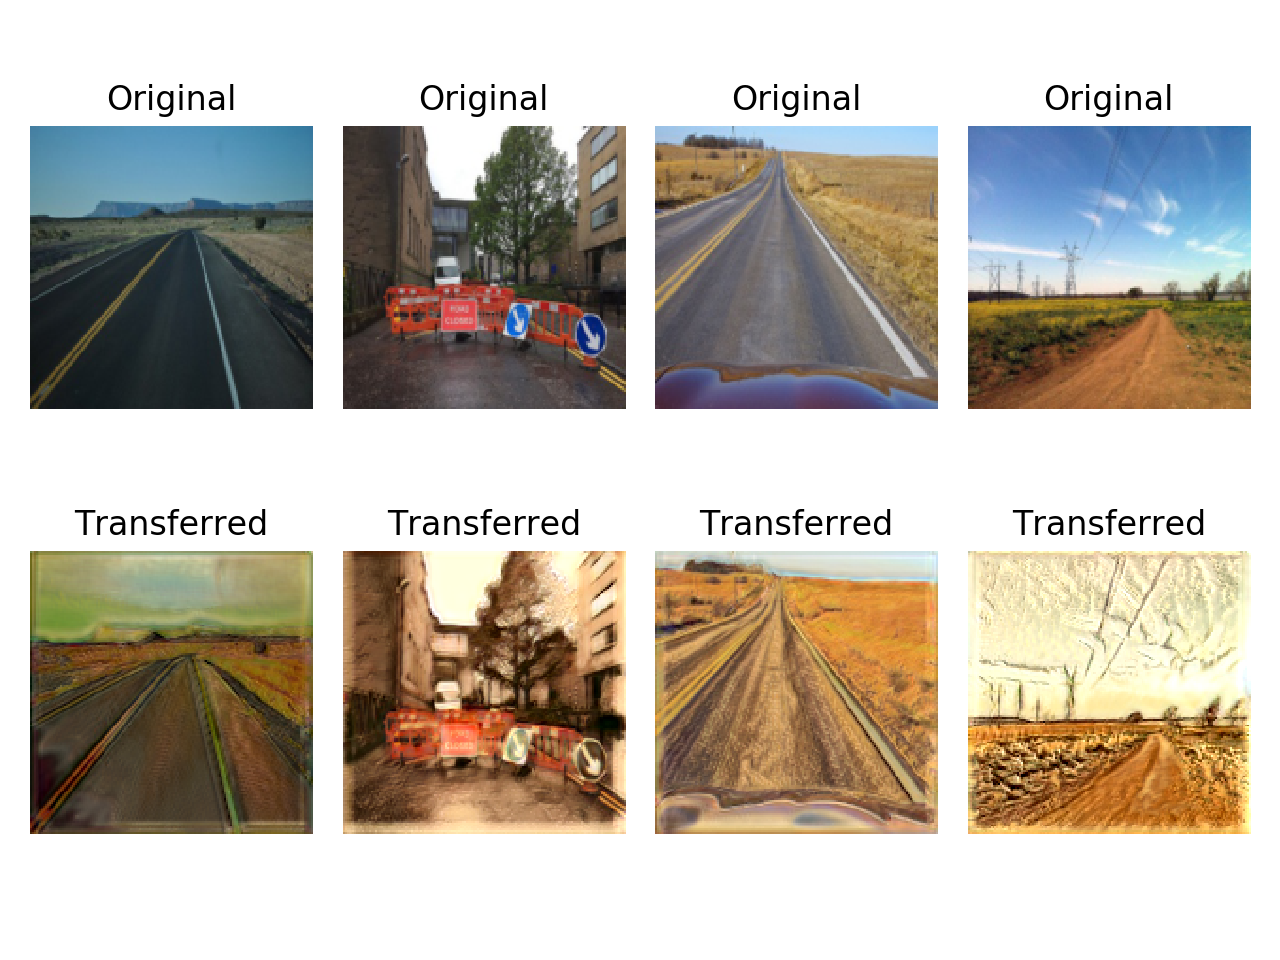

In [15]:
multi_final_result("domain_exp_largeBS_decay.png", False, domain_exp_largeBS_decay, 230, 231, 300, 330)

## The following code blocks are good model but not good enough cases

### Train & Test for domain_exp_short

<IPython.core.display.Javascript object>


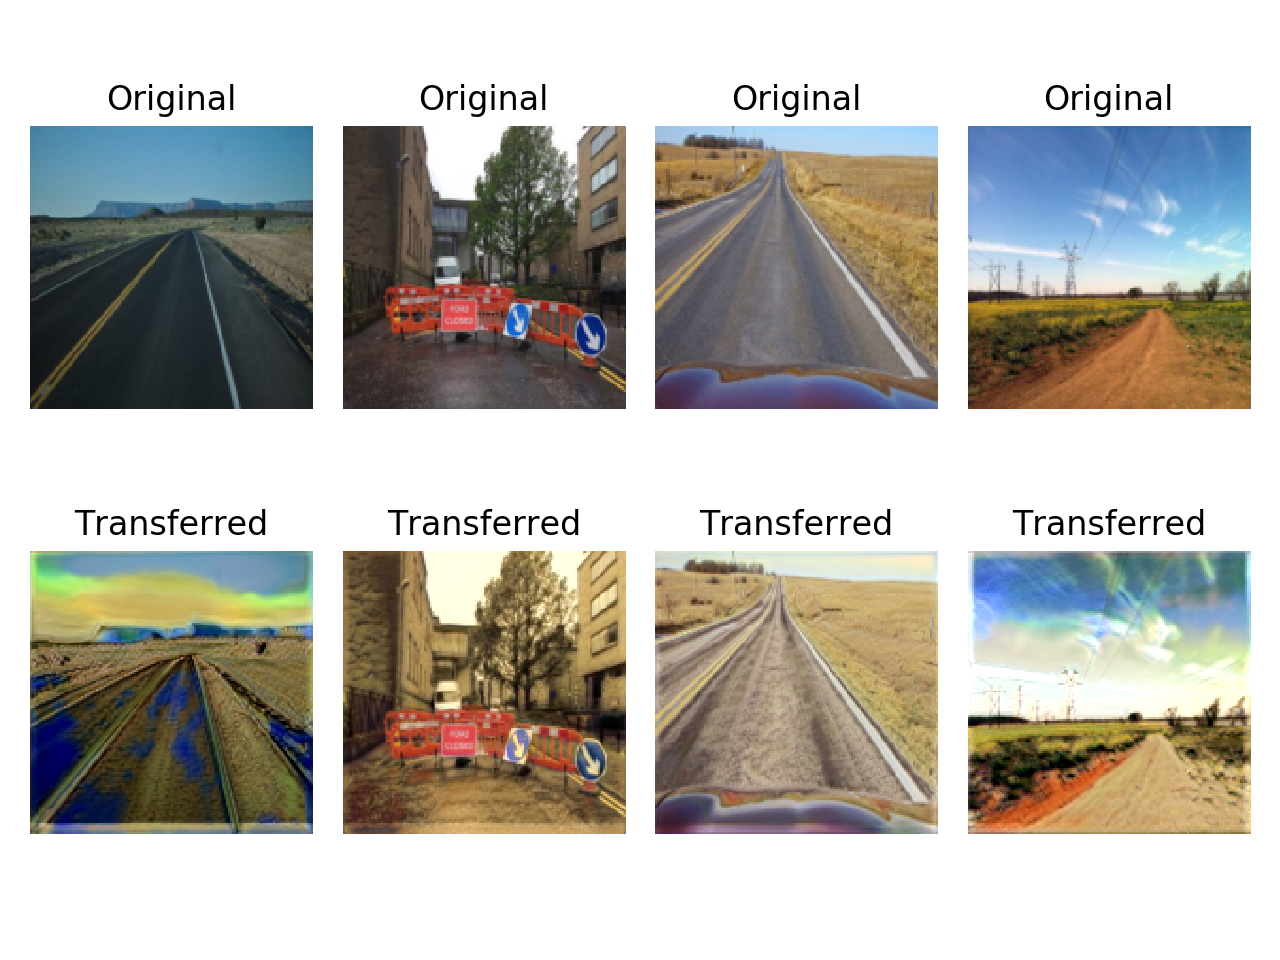

In [16]:
multi_final_result("domain_exp_short.png", False, domain_exp_short, 230, 231, 300, 330)

Start/Continue training from epoch 200


<IPython.core.display.Javascript object>


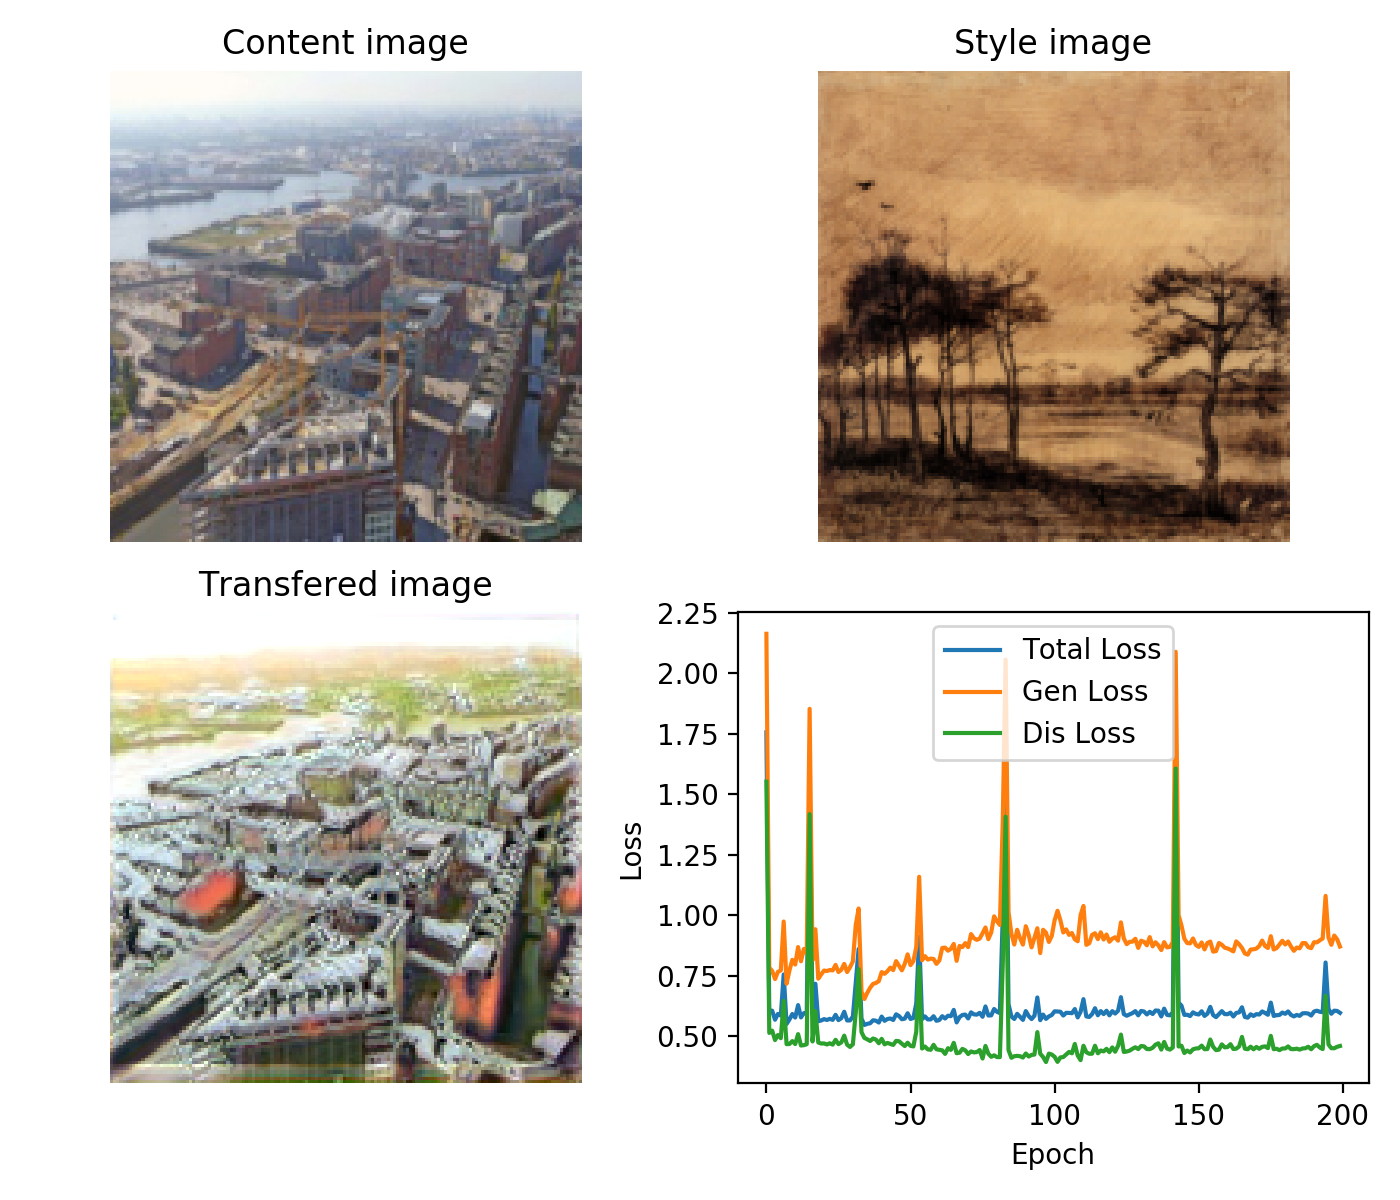

In [17]:
domain_exp_short.run(num_epochs=200, plot=plot_exp, save_path="domain_exp_short_train.png")

### Train & Test for domain_exp_long

Start/Continue training from epoch 200


<IPython.core.display.Javascript object>


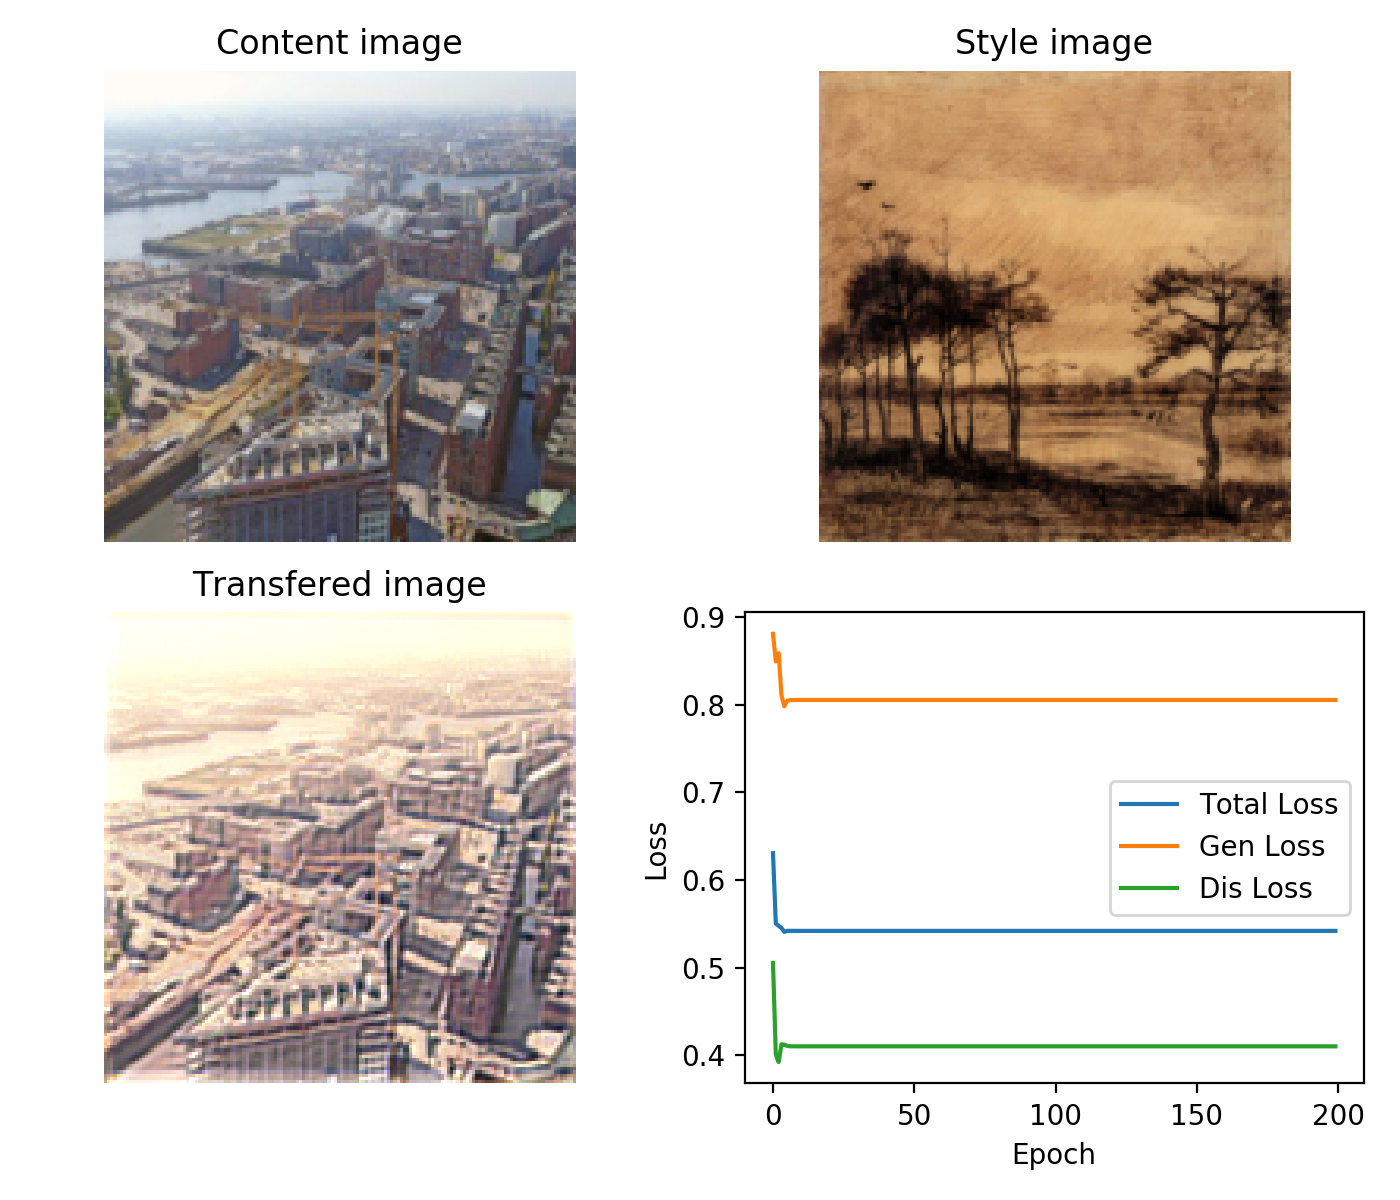

In [18]:
domain_exp_long.run(num_epochs=200, plot=plot_exp)

<IPython.core.display.Javascript object>


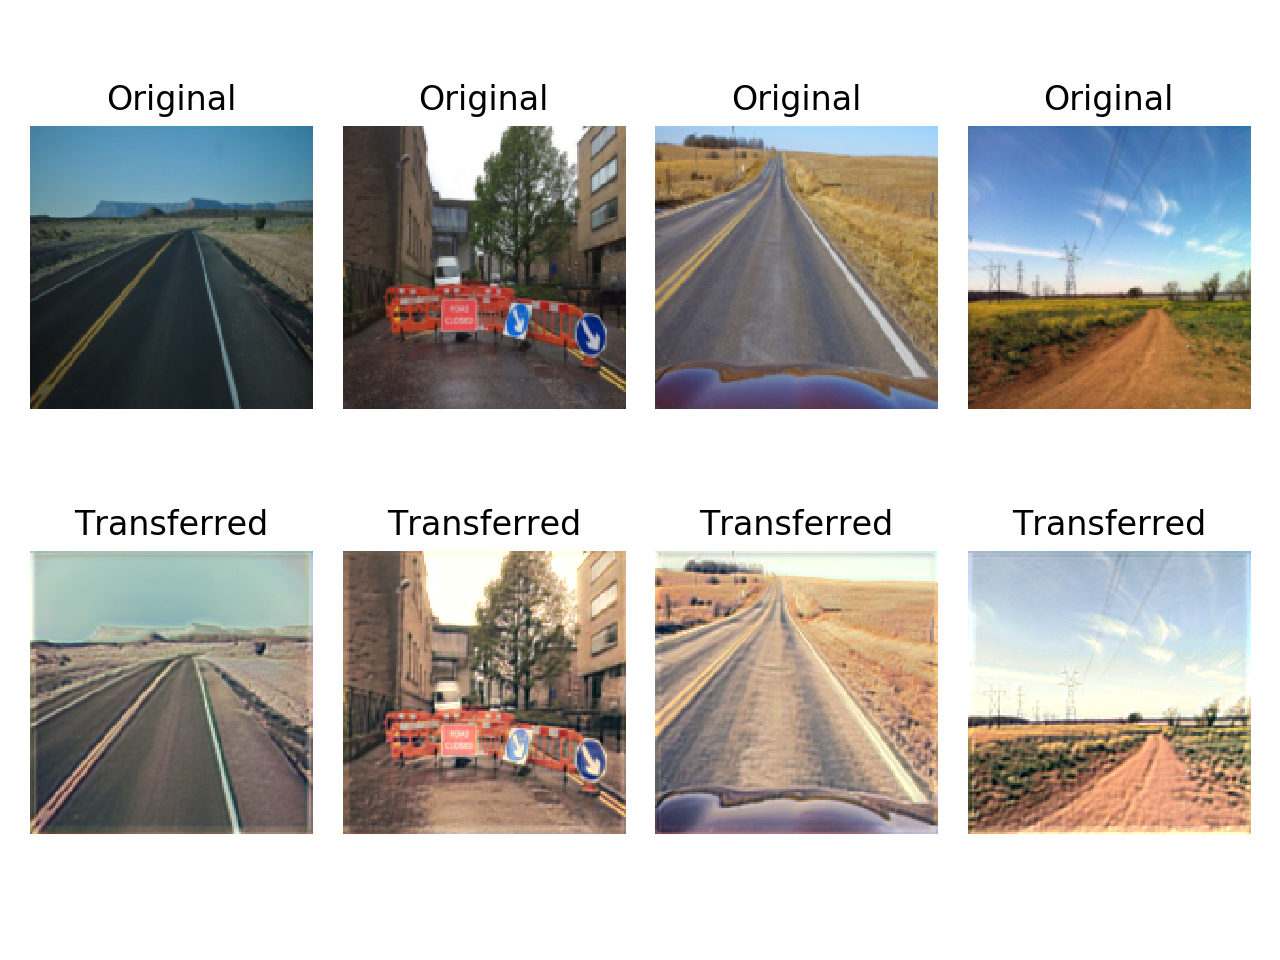

In [19]:
multi_final_result(None, False, domain_exp_long, 230, 231, 300, 330)

## The following code blocks are failure cases

Done Load from Checkpoint!
Start/Continue training from epoch 200


<IPython.core.display.Javascript object>


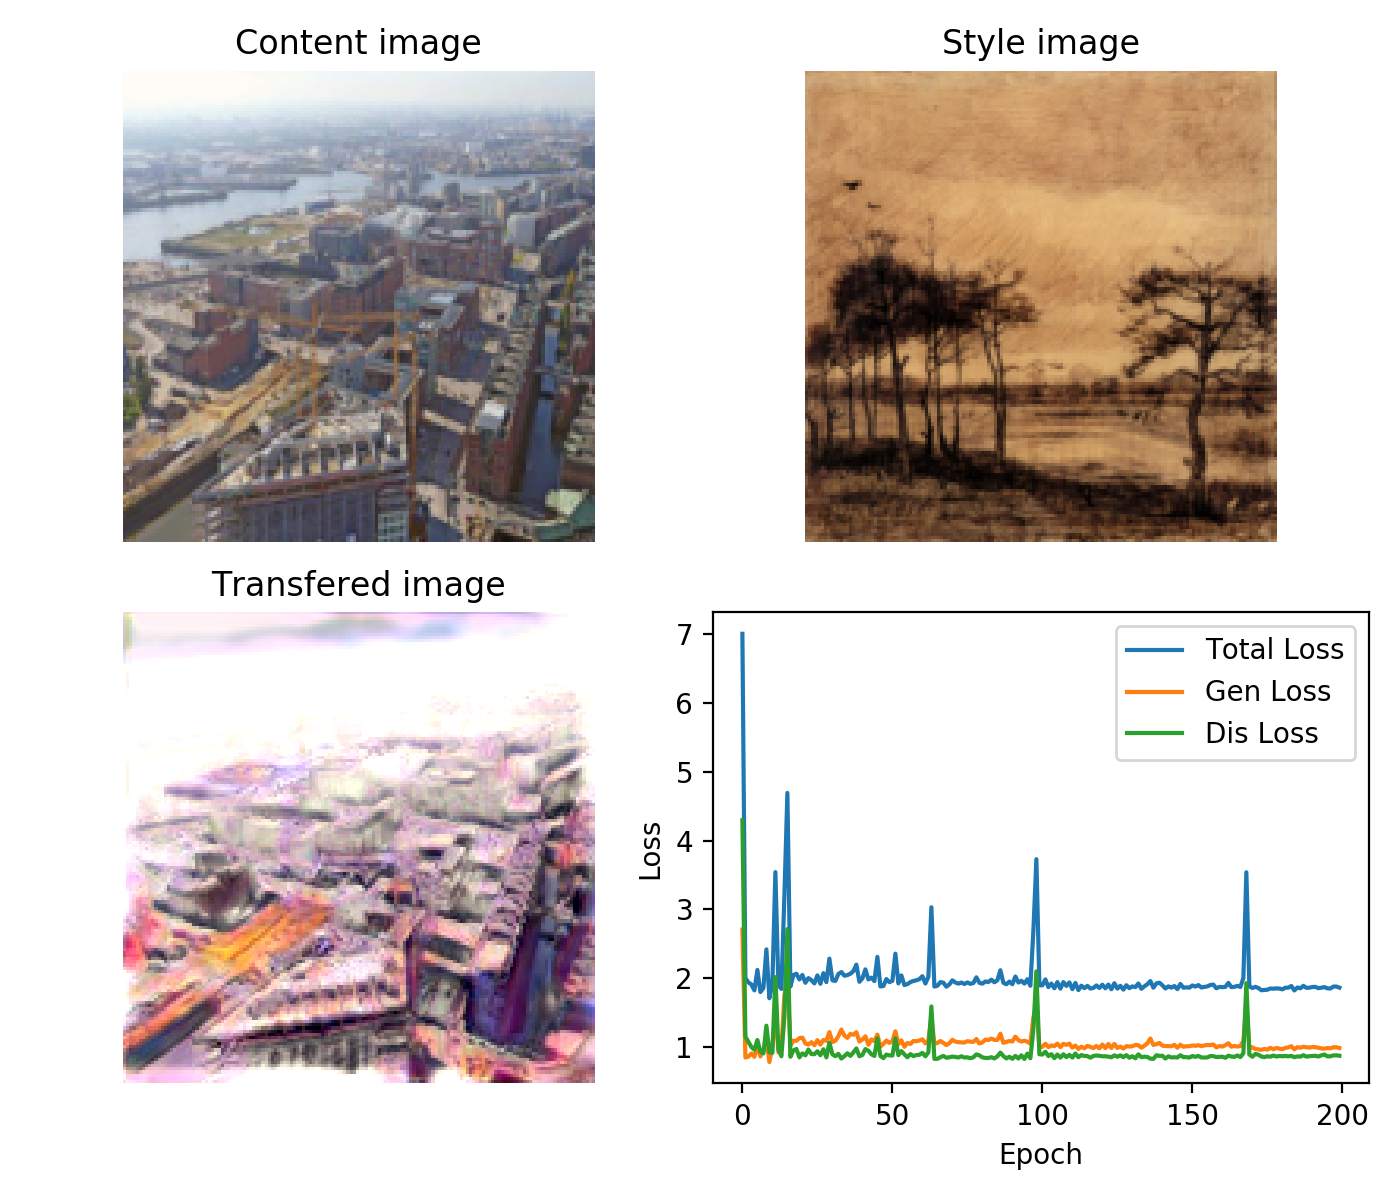

<IPython.core.display.Javascript object>


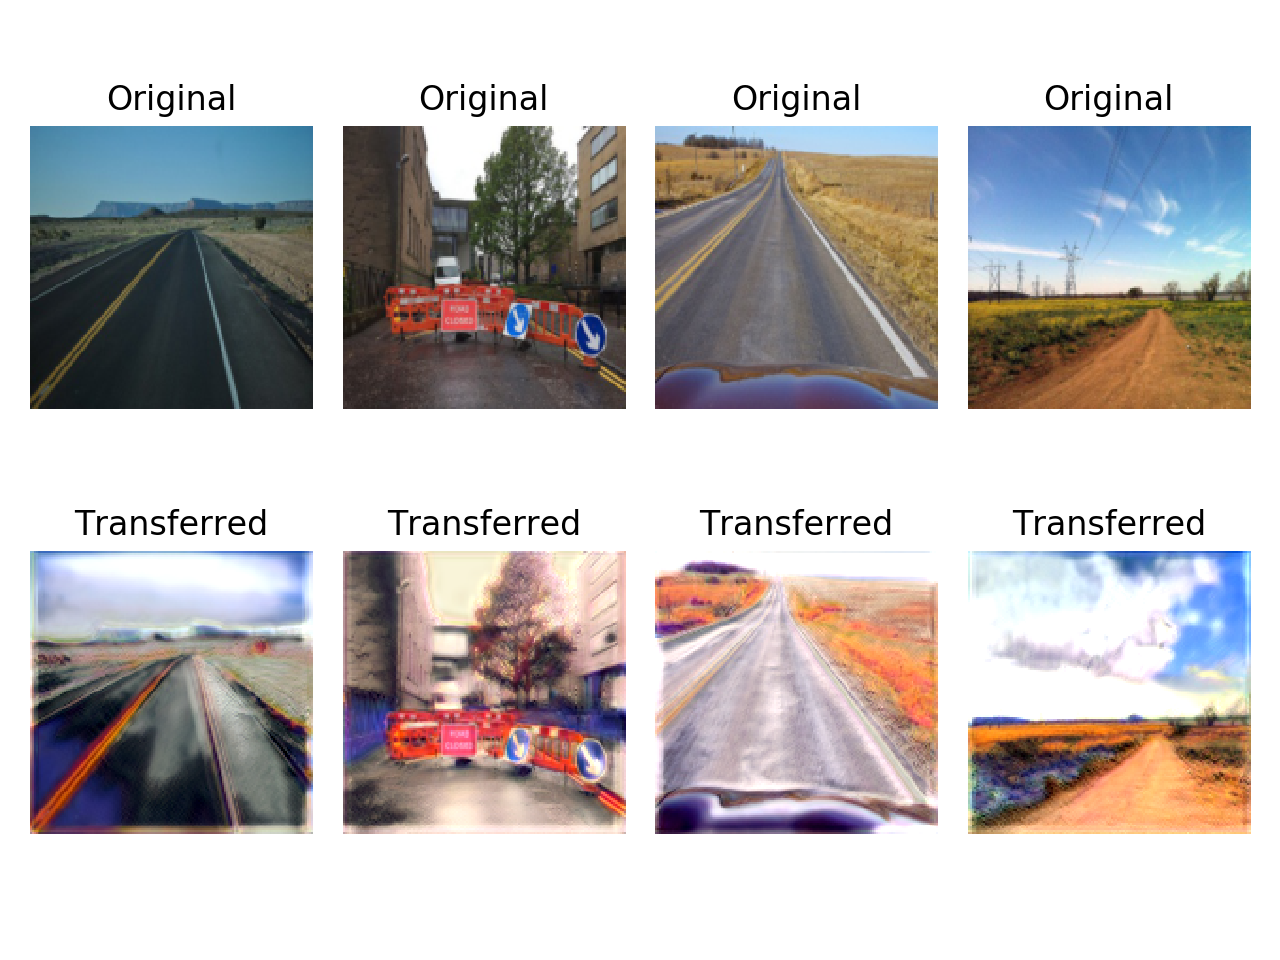

In [20]:
cycleGan_trainer_decay_short = CGANTrainer(device)
domain_exp_decay = CGANexp(cycleGan_trainer_decay_short, train_set, 
                           output_dir="./cGAN_ckpts/decay_small", 
                           style_ref = None, batch_size = 4, picNum = 20, 
                           perform_validation_during_training=True)
domain_exp_decay.run(num_epochs=200, plot=plot_exp)
multi_final_result(None, False, domain_exp_decay, 230, 231, 300, 330)